In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.imdb_data as imdb_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

No cuda.


In [4]:
corpus = imdb_data.ImdbCorpus(filename=settings.speaker_id_file, lines=settings.lines_id, 
                              text_col='text', tag_col='tag',
                              vocab_file='vocab.p'
                             )
corpus.train.itoklist_df.head()

Importing vocab from vocab.p... Done.
Imported vocab:  10,954
Read total of: 871 lines from imdb file.
Number of classes: 3: {'Doctor': 0, 'Patient': 1, 'Other': 2}
Generated train: 609 lines
Generated valid: 131 lines
Generated test:  131 lines


/anaconda3/envs/ONE/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/ONE/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,tag,text,len
425,2,"[3, 27, 149, 158, 2, 3, 2, 2, 165, 149, 203, 6...",15
462,0,"[3, 7893, 16, 1]",4
710,0,"[3, 2, 2, 16, 1]",5
666,1,"[3, 293, 725, 340, 2, 47, 2, 1828, 16, 1]",10
443,0,"[3, 470, 2, 452, 216, 2, 2, 3, 925, 2, 470, 28...",17


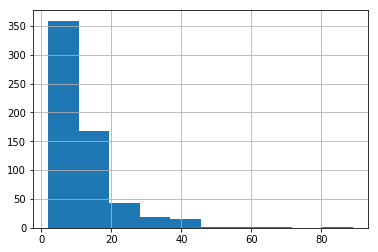

In [5]:
corpus.train.itoklist_df['len'].hist()

In [6]:
train_dl = imdb_data.ImdbTextDataset(corpus.train, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                     rand_range=5, sort=True, rebatch_and_shuffle=True)
valid_dl = imdb_data.ImdbTextDataset(corpus.valid, pad_idx=corpus.vocab.stoi['<pad>'],
                                     batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                     rand_range=5, sort=True)
test_dl = imdb_data.ImdbTextDataset(corpus.test, pad_idx=corpus.vocab.stoi['<pad>'],
                                    batch_size=settings.batch_size_id, seq_length=settings.window_size_id, 
                                    rand_range=5, sort=True)

 Number of batches: 10
 Preserved texts: 600
 Matrix size:       torch.Size([127, 60])
 Number of batches: 2
 Preserved texts: 120
 Matrix size:       torch.Size([30, 60])
 Number of batches: 2
 Preserved texts: 120
 Matrix size:       torch.Size([33, 60])


In [7]:
if in_notebook:
    for idx, (train_x, train_y) in enumerate(train_dl):
        print(idx, train_x.shape)
        print(train_y)
        print(train_dl.itoklistFrame.batch_start_end)
        if idx == 8:
            break

0 torch.Size([20, 60])
tensor([2, 1, 2, 0, 2, 2, 1, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0,
        1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 0, 1])
[[67, 88], [14, 20], [0, 6], [33, 40], [109, 127], [88, 109], [20, 33], [40, 51], [51, 67], [6, 14]]
1 torch.Size([5, 60])
tensor([2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0,
        0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0,
        2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2])
[[67, 88], [14, 20], [0, 6], [33, 40], [109, 127], [88, 109], [20, 33], [40, 51], [51, 67], [6, 14]]
2 torch.Size([5, 60])
tensor([0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0,
        1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2])
[[67, 88], [14, 20], [0, 6], [33, 40], [109, 127], [88, 109], [20, 33], [40, 51], [51, 67], [6, 14]]
3 torch.Size([6

In [8]:
lengths = np.array(train_dl.itoklistFrame.batch_start_end)
lengths = lengths[:,1] - lengths[:,0]
print('sequence lengths per batch:')
print(lengths)

sequence lengths per batch:
[21  6  6  7 18 21 13 11 16  8]


In [9]:
if in_notebook:
    for idx, (x, y) in enumerate(train_dl):
        if idx >= 5:
            break
        print(idx, len(x[:,1]))
        for i in x[:,1]:
            print(corpus.vocab.itos[i], end=' ')
        print('##', corpus.classes.itos[y[1].item()], '##')

0 20
<upcase> all right . <upcase> <unk> let me ask you this . <eol> <pad> <pad> <pad> <pad> <pad> <pad> <pad> ## Patient ##
1 5
<upcase> <unk> . <eol> <pad> ## Doctor ##
2 5
<unk> <eol> <pad> <pad> <pad> ## Doctor ##
3 6
<upcase> <unk> about two hours . ## Patient ##
4 17
<upcase> <unk> <unk> <unk> this is normal . <upcase> most people have some difficulty a couple of ## Doctor ##


In [10]:
model = neural.class_model_LSTM(vocab_dim=len(corpus.vocab),
                                emb_dim=settings.emb_dim,
                                hidden_dim=settings.hidden_dim,
                                n_layers=settings.num_layers,
                                dropout=settings.dropout,
                                n_classes=corpus.n_classes
                               )

In [11]:
if cuda:
    model = model.cuda()

In [12]:
print(model)

class_model_LSTM(
  (embedding): Embedding(10954, 50)
  (lstm): LSTM(50, 300, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
  (dropout): Dropout(p=0.4)
)


In [13]:
if in_notebook:
    x, y = next(iter(train_dl))
    print(x.shape)
    print(x)
    print(y.shape)
    preds = model(x)
    print(preds.shape)
    print(y)
    print(preds)
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(preds, y.long())

torch.Size([20, 60])
tensor([[   3,    3,    3,  ...,    3,    3,   16],
        [9474,  564,    2,  ...,  725,   79,   16],
        [1435, 4704,  504,  ...,    2,  725,   16],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])
torch.Size([60])
torch.Size([60, 3])
tensor([2, 1, 2, 0, 2, 2, 1, 2, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1,
        1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0,
        1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 0, 1])
tensor([[ 0.0150,  0.0087, -0.0065],
        [ 0.0097, -0.0184, -0.0145],
        [ 0.0270,  0.0233,  0.0023],
        [ 0.0130,  0.0159,  0.0048],
        [ 0.0267,  0.0136,  0.0067],
        [ 0.0262, -0.0081, -0.0055],
        [ 0.0026,  0.0108,  0.0205],
        [ 0.0021,  0.0042, -0.0013],
        [ 0.0135,  0.0156,  0.0006],
        [ 0.0174,  0.0006, -0.0057],
        [ 0.0085,  0.0105,  0.0285],
    

In [14]:
#model = torch.load('model_weights_speaker_id.pt')

In [15]:
missclass = []
missclass_next = []
losses = []

In [16]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds, y.long())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=1)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds, y.long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=1)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          missclass_tr, missclass_te))
            sys.stdout.flush()

            if missclass_te < best_missclass_te:
                print('Improved validation. Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights_speaker_id.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [17]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Valid 1/50: 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]

Epoch: 1/50, Loss: [0.2005, 0.2362], Miss: [64.33%, 54.17%]
Improved validation. Saving weights file... Done.



Valid 2/50: 100%|██████████| 2/2 [00:00<00:00, 14.63it/s]

Epoch: 2/50, Loss: [0.2186, 0.2209], Miss: [51.33%, 39.17%]
Improved validation. Saving weights file... Done.



Valid 3/50: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s]

Epoch: 3/50, Loss: [0.1780, 0.2096], Miss: [41.33%, 44.17%]



Valid 4/50: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s]

Epoch: 4/50, Loss: [0.1676, 0.2472], Miss: [40.50%, 43.33%]



Valid 5/50: 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]

Epoch: 5/50, Loss: [0.2200, 0.2562], Miss: [35.83%, 38.33%]
Improved validation. Saving weights file... Done.



Valid 6/50: 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]

Epoch: 6/50, Loss: [0.1583, 0.1990], Miss: [32.17%, 35.83%]
Improved validation. Saving weights file... Done.



Valid 7/50: 100%|██████████| 2/2 [00:00<00:00, 14.86it/s]

Epoch: 7/50, Loss: [0.1277, 0.2650], Miss: [33.83%, 46.67%]



Valid 8/50: 100%|██████████| 2/2 [00:00<00:00, 12.75it/s]

Epoch: 8/50, Loss: [0.1239, 0.2470], Miss: [29.67%, 42.50%]



Valid 9/50: 100%|██████████| 2/2 [00:00<00:00, 13.32it/s]

Epoch: 9/50, Loss: [0.1143, 0.1938], Miss: [26.83%, 31.67%]
Improved validation. Saving weights file... Done.



Valid 10/50: 100%|██████████| 2/2 [00:00<00:00, 13.46it/s]

Epoch: 10/50, Loss: [0.1139, 0.2342], Miss: [25.33%, 34.17%]



Valid 11/50: 100%|██████████| 2/2 [00:00<00:00, 14.87it/s]

Epoch: 11/50, Loss: [0.1063, 0.2025], Miss: [25.17%, 34.17%]



Valid 12/50: 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

Epoch: 12/50, Loss: [0.0909, 0.2369], Miss: [24.17%, 39.17%]



Valid 13/50: 100%|██████████| 2/2 [00:00<00:00, 13.87it/s]

Epoch: 13/50, Loss: [0.1719, 0.2159], Miss: [24.83%, 41.67%]



Valid 14/50: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s]

Epoch: 14/50, Loss: [0.1004, 0.3650], Miss: [21.83%, 36.67%]



Valid 15/50: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

Epoch: 15/50, Loss: [0.1805, 0.4413], Miss: [24.67%, 37.50%]



Valid 16/50: 100%|██████████| 2/2 [00:00<00:00, 13.58it/s]

Epoch: 16/50, Loss: [0.0739, 0.4205], Miss: [20.00%, 50.83%]



Valid 17/50: 100%|██████████| 2/2 [00:00<00:00, 13.72it/s]

Epoch: 17/50, Loss: [0.0928, 0.3679], Miss: [21.33%, 42.50%]



Valid 18/50: 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]

Epoch: 18/50, Loss: [0.0942, 0.2217], Miss: [19.83%, 42.50%]



Valid 19/50: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]

Epoch: 19/50, Loss: [0.0827, 0.2985], Miss: [20.33%, 37.50%]



Valid 20/50: 100%|██████████| 2/2 [00:00<00:00, 13.23it/s]

Epoch: 20/50, Loss: [0.0894, 0.3056], Miss: [20.33%, 47.50%]



Valid 21/50: 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]

Epoch: 21/50, Loss: [0.1003, 0.2963], Miss: [24.17%, 33.33%]



Valid 22/50: 100%|██████████| 2/2 [00:00<00:00, 12.73it/s]

Epoch: 22/50, Loss: [0.0702, 0.2702], Miss: [19.00%, 40.00%]



Valid 23/50: 100%|██████████| 2/2 [00:00<00:00, 12.92it/s]

Epoch: 23/50, Loss: [0.0639, 0.3121], Miss: [17.67%, 36.67%]



Valid 24/50: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s]

Epoch: 24/50, Loss: [0.0893, 0.3238], Miss: [18.17%, 35.00%]



Valid 25/50: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]

Epoch: 25/50, Loss: [0.0622, 0.2768], Miss: [17.17%, 36.67%]



Valid 26/50: 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]

Epoch: 26/50, Loss: [0.0687, 0.3413], Miss: [16.33%, 36.67%]



Valid 27/50: 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]

Epoch: 27/50, Loss: [0.0503, 0.3662], Miss: [16.50%, 30.83%]
Improved validation. Saving weights file... 

Done.


Valid 28/50: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

Epoch: 28/50, Loss: [0.0620, 0.3634], Miss: [16.67%, 39.17%]



Valid 29/50: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Epoch: 29/50, Loss: [0.0647, 0.3264], Miss: [21.33%, 42.50%]



Valid 30/50: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

Epoch: 30/50, Loss: [0.0536, 0.3295], Miss: [14.83%, 33.33%]



Valid 31/50: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

Epoch: 31/50, Loss: [0.0485, 0.3887], Miss: [15.00%, 34.17%]



Valid 32/50: 100%|██████████| 2/2 [00:00<00:00, 10.27it/s]

Epoch: 32/50, Loss: [0.0351, 0.4432], Miss: [14.00%, 35.00%]



Valid 33/50: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

Epoch: 33/50, Loss: [0.0464, 0.4688], Miss: [14.50%, 36.67%]



Valid 34/50: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

Epoch: 34/50, Loss: [0.0509, 0.3931], Miss: [14.67%, 37.50%]



Valid 35/50: 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

Epoch: 35/50, Loss: [0.0503, 0.4919], Miss: [16.33%, 32.50%]



Valid 36/50: 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]

Epoch: 36/50, Loss: [0.0486, 0.4118], Miss: [14.50%, 33.33%]



Valid 37/50: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

Epoch: 37/50, Loss: [0.0466, 0.4751], Miss: [13.67%, 34.17%]



Valid 38/50: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

Epoch: 38/50, Loss: [0.0473, 0.4843], Miss: [13.67%, 33.33%]



Valid 39/50: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]

Epoch: 39/50, Loss: [0.0361, 0.5165], Miss: [13.00%, 33.33%]



Valid 40/50: 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

Epoch: 40/50, Loss: [0.0418, 0.5586], Miss: [13.50%, 32.50%]



Valid 41/50: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

Epoch: 41/50, Loss: [0.0445, 0.5192], Miss: [13.50%, 34.17%]



Valid 42/50: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]

Epoch: 42/50, Loss: [0.0459, 0.5591], Miss: [13.00%, 37.50%]



Valid 43/50: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]

Epoch: 43/50, Loss: [0.0482, 0.5391], Miss: [15.00%, 47.50%]



Valid 44/50: 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

Epoch: 44/50, Loss: [0.0368, 0.5165], Miss: [13.33%, 50.83%]



Valid 45/50: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

Epoch: 45/50, Loss: [0.0507, 0.5174], Miss: [18.33%, 40.83%]



Valid 46/50: 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

Epoch: 46/50, Loss: [0.0430, 0.5605], Miss: [14.33%, 35.00%]



Valid 47/50: 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

Epoch: 47/50, Loss: [0.0325, 0.4592], Miss: [14.00%, 32.50%]



Valid 48/50: 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]

Epoch: 48/50, Loss: [0.0522, 0.4966], Miss: [14.00%, 34.17%]



Valid 49/50: 100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

Epoch: 49/50, Loss: [0.0327, 0.5464], Miss: [13.00%, 45.00%]



Valid 50/50: 100%|██████████| 2/2 [00:00<00:00, 10.75it/s]

Epoch: 50/50, Loss: [0.0397, 0.4817], Miss: [12.17%, 35.00%]


In [18]:
loss_func(preds, y.long())

tensor(1.0988, grad_fn=<NllLossBackward>)

In [19]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=1)
loss = loss_func(preds, y.long())
loss

tensor(2.4376, grad_fn=<NllLossBackward>)

In [20]:
print(y.shape)
print(y[:])

torch.Size([60])
tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0])


In [21]:
print(y_preds[:])
print(preds)

tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 0, 0])
tensor([[-2.0909,  3.9862, -2.7688],
        [ 5.2209, -2.4705, -1.8312],
        [ 1.3287,  0.2348, -1.3405],
        [ 0.7436,  1.0162, -1.6292],
        [-3.8635,  4.8715, -2.1264],
        [-1.8764,  1.2000,  0.4150],
        [ 0.7499, -0.2540, -0.2328],
        [ 8.8264, -4.8610, -2.5944],
        [-3.2668,  4.4807, -2.2679],
        [ 1.1431, -0.7095,  0.0103],
        [ 6.6519, -2.7940, -2.6045],
        [-1.3701,  1.6297, -0.6705],
        [ 4.0980, -1.7180, -1.5737],
        [-2.4706,  3.7235, -1.9610],
        [ 0.3432, -2.8342,  2.4662],
        [ 8.2872, -4.3719, -2.5605],
        [ 8.4163, -4.8289, -2.3416],
        [ 4.0678, -4.5323,  1.4861],
        [-5.0503,  7.3283, -4.0191],
        [ 1.3042,  1.4753, -2.5087],
        [ 3.7113, -1.9061, -0.9346],
        [-2.8638, 

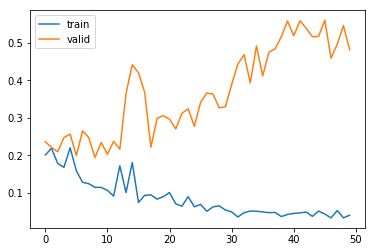

In [22]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

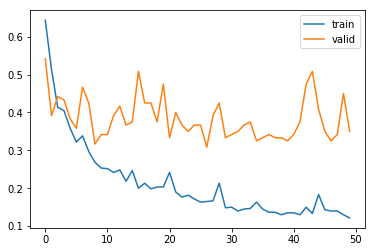

In [23]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])